### 필요한 라이브러리 import

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import urllib3

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- The convolutional layers mostly have 3×3 filters and follow two simple design rules:   
    1.  for the same output feature map size, the layers have the same number of filters   
    2.  if the feature map size is halved, the number of filters is doubled so as to preserve the time complexity per layer. We perform downsampling directly by convolutional layers that have a stride of 2. The network ends with a global average pooling layer and a 1000-way fully-connected layer with softmax   
    
     Downsampling is performed by conv3 1, conv4 1, and conv5 1 with a stride of 2.

- Residual Network   
    The identity shortcuts $y = F(x, \{W_i\}) + x$ can be directly used when the input and output are of the same dimensions   
    
    When the dimensions increase, we consider two options: 
    1. The shortcut still performs identity mapping, with extra zero entries padded for increasing dimensions. This option introduces no extra parameter
    2. The projection shortcut in $y = F(x, \{W_i\}) + W_ix$ is used to match dimensions (done by 1×1 convolutions). For both options, when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2. (X)   

The operation $F + x$ is performed by a shortcut connection and element-wise addition.   
We adopt the second nonlinearity after the addition

- batch normalization right after each convolution and before activation
- initialize the weights as in <K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In ICCV, 2015.> and train all plain/residual nets from scratch
- use SGD with a mini-batch size of 256. (for ImageNet)
- The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to $60\times{10^4}$ iterations. (오바)
- use a weight decay of 0.0001 and a momentum of 0.9.
- do not use dropout

- 50-layer ResNet   
    We replace each 2-layer block in the 34-layer net with this 3-layer bottleneck block.   
        For each residual function F, we use a stack of 3 layers instead of 2.
        The three layers are 1×1, 3×3, and 1×1 convolutions.

### ResNet 기본 블록 구성하기

In [3]:
def conv_block(tensor, filters=64, strides=1, kernel_size=3, block_num=0, cnn_num=0, desc=0):
    """
    desc == 0 : short
    else : other convolution layers
    """
    conv_name = f'stage{block_num}_{cnn_num+1}_'+ ("short" if desc==0 else f"conv{desc}")
    bn_name = None if desc==0 else f"stage{block_num}_{cnn_num+1}_" + f"bn{desc}"
    
    output = keras.layers.Conv2D(
        filters=filters,
        strides=strides,
        kernel_size=kernel_size,
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        padding='same',
        name=conv_name
    )(tensor)
    output = keras.layers.BatchNormalization(name=bn_name)(output)
    if desc != 0:
        output = keras.layers.Activation('relu')(output)
    
    return output

In [4]:
def build_conv1(tensor):
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=(2,2),
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        padding='same'
    )(tensor)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    
    return output

In [5]:
def build_maxpooling2d(tensor):
    return keras.layers.MaxPooling2D(
        pool_size=(3,3),
        strides=(2,2),
        padding='same',
        name='stage2_0_maxpooling'
    )(tensor)

In [6]:
def build_resnet34_block(input_layer, num_cnn=3, channel=64, block_num=2, residual=True):
    x = input_layer
    y = input_layer

    for cnn_num in range(num_cnn):
        y = conv_block(y, channel, 2 if cnn_num==0 and block_num>2 else 1, 3, block_num, cnn_num, 1)
        y = conv_block(y, channel, 1, 3, block_num, cnn_num, 2)

        if cnn_num==0:
            x = conv_block(x, channel, 2 if block_num>2 else 1, 1, block_num, cnn_num)

        if residual:
            y = keras.layers.Add()([x, y])
            
    return y

In [7]:
def build_resnet50_block(input_layer, num_cnn=3, channel=64, block_num=2, residual=True
                        ):
    x = input_layer
    y = input_layer

    for cnn_num in range(num_cnn):
        y = conv_block(y, channel, 2 if cnn_num==0 and block_num>2 else 1, 1, block_num, cnn_num, 1)
        y = conv_block(y, channel, 1, 3, block_num, cnn_num, 2)
        y = conv_block(y, channel*4, 1, 1, block_num, cnn_num, 3)

        if cnn_num==0:
            x = conv_block(x, channel*4, 2 if block_num>2 else 1, 1, block_num, cnn_num)
        
        if residual:
            y = keras.layers.Add()([x, y])
            
    return y

### ResNet-34, ResNet-50 Complete Model

In [8]:
def build_resnet(input_shape=(32,32,3),
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   residual=True, 
                 is_50=False
                  ):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    
    output = build_conv1(output)
    output = build_maxpooling2d(output)
    
    if is_50:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output = build_resnet50_block(
                output,
                num_cnn=num_cnn, 
                channel=channel,
                block_num=i+2,
                residual=residual
        )
    else:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output = build_resnet34_block(
                output,
                num_cnn=num_cnn, 
                channel=channel,
                block_num=i+2,
                residual=residual
        )        
    output = keras.layers.AveragePooling2D(pool_size=(1,1))(output)
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc10')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [9]:
resnet_34 = build_resnet()
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
resnet_50 = build_resnet(is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

### 일반 네트워크(plain network) 만들기

In [11]:
# 불필요한데 노드에 구현하라고 나와서 그냥 구현

def build_plainnet(input_shape=(224,224,3), is_50=False):
    return build_resnet(input_shape=input_shape, 
                        is_50=is_50, 
                        residual=False)

In [12]:
resnet34_plain = build_plainnet()
resnet34_plain.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_10 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [13]:
resnet50_plain = build_plainnet(is_50=True)
resnet50_plain.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_15 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

### ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [14]:
# 작은 데이터셋에 대해 batch size가 크면 UnboundLocalError: local variable 'logs' referenced before assignment

BATCH_SIZE = 16
EPOCH = 10

In [15]:
# cats vs dogs 데이터셋
# https://east-rain.github.io/docs/Deep%20Learning/tensorflow%20tutorial/image_transfer_learning_preTrained.html

urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
)

In [16]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [17]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [18]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [19]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
ds_info.features["label"].num_classes

2

In [21]:
ds_info.features["label"].names

['cat', 'dog']

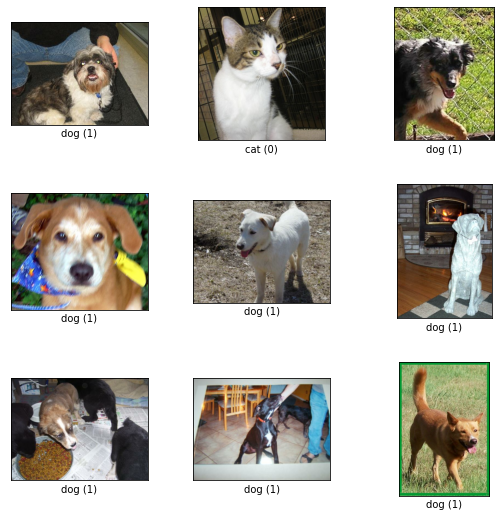

In [22]:
fig = tfds.show_examples(ds_train, ds_info)

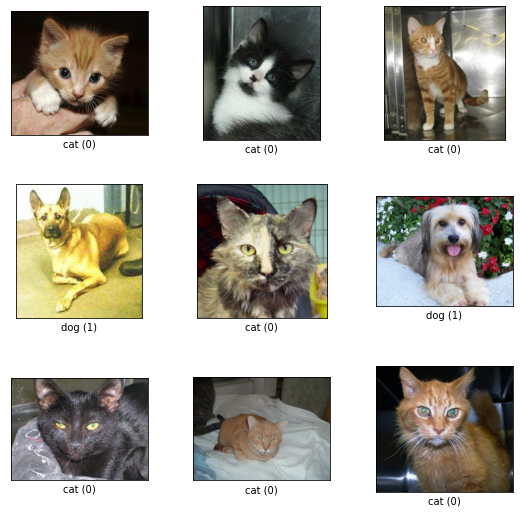

In [23]:
fig = tfds.show_examples(ds_test, ds_info)

In [24]:
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, is_test=False, batch_size=BATCH_SIZE)

In [25]:
resnet34 = build_resnet(input_shape=(224,224,3), num_classes=2)
resnet34.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 112, 112, 64) 256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_164 (Activation)     (None, 112, 112, 64) 0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [25]:
"""
binary classification 문제에 대해 모델이 multiclass classification을 기준으로 짜여졌다면,
num_classes=2 + sparse_categorical_crossentropy이 num_classes=1 + binary_crossentropy보다 적합한듯.
optimizer를 바꾸는 것은 큰 영향이 없었음
"""
resnet34.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
)

history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
)

Epoch 1/10
1163/1163 [==============================] - 126s 108ms/step - loss: 1.3440 - accuracy: 0.5964 - val_loss: 0.6174 - val_accuracy: 0.6611
Epoch 2/10
1163/1163 [==============================] - 97s 84ms/step - loss: 0.6111 - accuracy: 0.6680 - val_loss: 0.6011 - val_accuracy: 0.6792
Epoch 3/10
1163/1163 [==============================] - 99s 85ms/step - loss: 0.5753 - accuracy: 0.6910 - val_loss: 0.5998 - val_accuracy: 0.6969
Epoch 4/10
1163/1163 [==============================] - 97s 84ms/step - loss: 0.5527 - accuracy: 0.7142 - val_loss: 0.5818 - val_accuracy: 0.7172
Epoch 5/10
1163/1163 [==============================] - 97s 83ms/step - loss: 0.5287 - accuracy: 0.7312 - val_loss: 0.5575 - val_accuracy: 0.7211
Epoch 6/10
1163/1163 [==============================] - 97s 83ms/step - loss: 0.5017 - accuracy: 0.7512 - val_loss: 0.5261 - val_accuracy: 0.7446
Epoch 7/10
1163/1163 [==============================] - 98s 84ms/step - loss: 0.4840 - accuracy: 0.7611 - val_loss: 0.5005

In [26]:
resnet34_plain = build_resnet(input_shape=(224,224,3), num_classes=2, residual=False)
resnet34_plain.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_25 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_197 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [33]:
resnet34_plain.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
)

history_34_plain = resnet34_plain.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
)

Epoch 1/10
1163/1163 [==============================] - 91s 78ms/step - loss: 1.2862 - accuracy: 0.5042 - val_loss: 0.6928 - val_accuracy: 0.5136
Epoch 2/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6946 - accuracy: 0.4967 - val_loss: 0.6942 - val_accuracy: 0.4914
Epoch 3/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6942 - accuracy: 0.5012 - val_loss: 0.6930 - val_accuracy: 0.5110
Epoch 4/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6940 - accuracy: 0.5005 - val_loss: 0.6941 - val_accuracy: 0.4976
Epoch 5/10
1163/1163 [==============================] - 90s 77ms/step - loss: 0.6943 - accuracy: 0.5015 - val_loss: 0.6975 - val_accuracy: 0.4944
Epoch 6/10
1163/1163 [==============================] - 90s 77ms/step - loss: 0.6938 - accuracy: 0.5035 - val_loss: 0.6924 - val_accuracy: 0.5145
Epoch 7/10
1163/1163 [==============================] - 90s 77ms/step - loss: 0.6938 - accuracy: 0.5021 - val_loss: 0.6927 -

In [27]:
resnet50 = build_resnet(input_shape=(224,224,3), num_classes=2, is_50=True)
resnet50.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 112, 112, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 112, 112, 64) 256         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_230 (Activation)     (None, 112, 112, 64) 0           batch_normalization_30[0][0]     
____________________________________________________________________________________________

In [37]:
resnet50.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
)

history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
)

Epoch 1/10
1163/1163 [==============================] - 220s 189ms/step - loss: 3.4500 - accuracy: 0.5677 - val_loss: 0.6796 - val_accuracy: 0.5949
Epoch 2/10
1163/1163 [==============================] - 159s 137ms/step - loss: 0.6551 - accuracy: 0.6238 - val_loss: 0.6393 - val_accuracy: 0.6519
Epoch 3/10
1163/1163 [==============================] - 160s 137ms/step - loss: 0.6144 - accuracy: 0.6603 - val_loss: 0.6371 - val_accuracy: 0.6791
Epoch 4/10
1163/1163 [==============================] - 160s 138ms/step - loss: 0.5865 - accuracy: 0.6871 - val_loss: 0.6377 - val_accuracy: 0.6782
Epoch 5/10
1163/1163 [==============================] - 171s 147ms/step - loss: 0.5708 - accuracy: 0.7032 - val_loss: 0.6144 - val_accuracy: 0.7024
Epoch 6/10
1163/1163 [==============================] - 160s 138ms/step - loss: 0.5471 - accuracy: 0.7188 - val_loss: 0.6082 - val_accuracy: 0.7019
Epoch 7/10
1163/1163 [==============================] - 165s 142ms/step - loss: 0.5345 - accuracy: 0.7293 - val_

In [28]:
resnet50_plain = build_resnet(input_shape=(224,224,3), num_classes=2, residual=False, is_50=True)
resnet50_plain.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_35 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_279 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [39]:
resnet50_plain.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
)

history_50_plain = resnet50_plain.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
)

Epoch 1/10
1163/1163 [==============================] - 136s 117ms/step - loss: 4.7542 - accuracy: 0.5042 - val_loss: 0.7058 - val_accuracy: 0.5166
Epoch 2/10
1163/1163 [==============================] - 135s 116ms/step - loss: 0.6947 - accuracy: 0.5052 - val_loss: 0.6940 - val_accuracy: 0.4907
Epoch 3/10
1163/1163 [==============================] - 137s 118ms/step - loss: 0.6933 - accuracy: 0.5041 - val_loss: 0.6956 - val_accuracy: 0.4864
Epoch 4/10
1163/1163 [==============================] - 138s 119ms/step - loss: 0.6965 - accuracy: 0.5011 - val_loss: 0.6954 - val_accuracy: 0.5129
Epoch 5/10
1163/1163 [==============================] - 137s 118ms/step - loss: 0.6930 - accuracy: 0.5075 - val_loss: 0.6958 - val_accuracy: 0.4873
Epoch 6/10
1163/1163 [==============================] - 137s 118ms/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6962 - val_accuracy: 0.5157
Epoch 7/10
1163/1163 [==============================] - 137s 118ms/step - loss: 0.6931 - accuracy: 0.5061 - val_

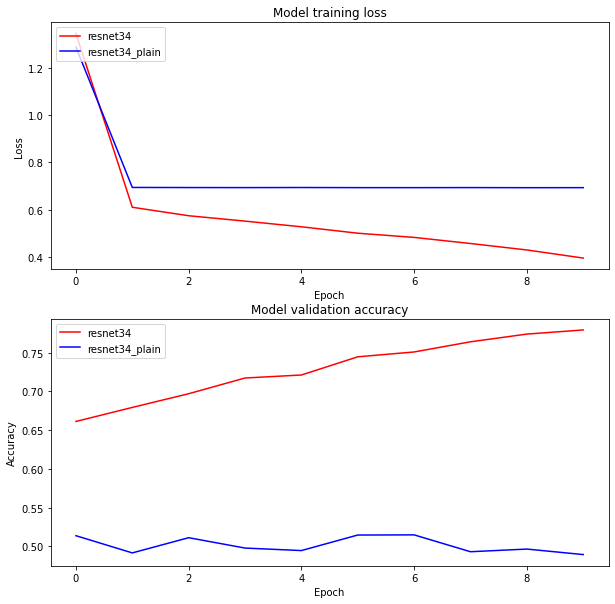

In [45]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet34_plain'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet34_plain'], loc='upper left')

plt.show()

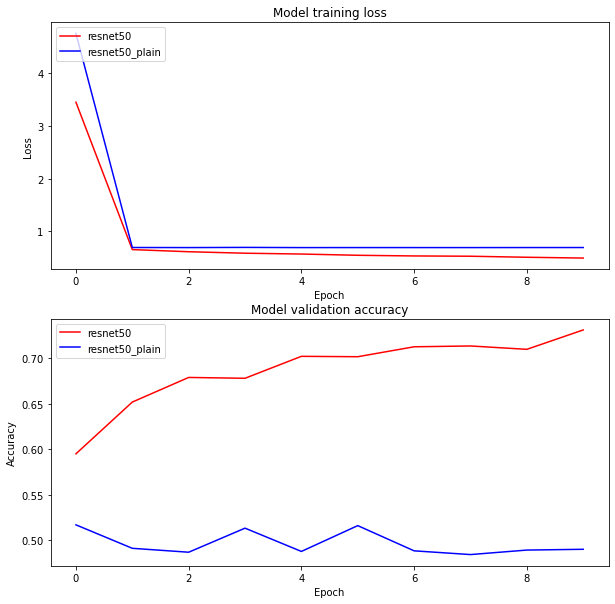

In [46]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'resnet50_plain'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'resnet50_plain'], loc='upper left')

plt.show()

EPOCH가 10일 때를 기준으로 validation accuracy는 다음과 같다.   

||validation accuracy|
|---|-------------------|
|resnet34|0.7793|
|resnet34_plain|0.4892|
|resnet50|0.7315|
|resnet50_plain|0.4896|

- resnet34   
stage2_1에선 downsampling이 일어나지 않고, 논문에서도 stage3_1, stage4_1, stage5_1에서만 일어난다고 했으므로, 노드 내용 중 stage2_1_short의 파라미터와 바로 연결된 batch normalization의 파라미터를 제거하면 총 파라미터의 수는 21,315,338이 된다.   
Non-trainable params의 수가 노드보다 적은 것도 이 부분과 관련이 있다.   
노드에 예시로 주어진 summary대로 하려면 stage2_1에서 stride을 1로 주고 1x1 convolution layer를 적용해야 하는데, 왜 그래야 할까?
   
- resnet50   
resnet50은 stage2_1에서도 1x1 convolution layer를 적용해야 키웠던 채널 값을 다시 줄여줄 수 있었다.